In [ ]:
import numpy as np
from pycbf.gpu import TabbedBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import pycbf.dataio as dio
from scipy.signal import hilbert
import os

In [29]:
from timuscle.autoprocessing.__rf_preproc__ import __GE9LD_SORT__ as reorg

In [30]:
path = "/fastrs/ultrasound/TIMuscle/ExVivo/20250429_embedded_test/beef_rswei/SSI_radius_1000.00/acq_001/RawData"

rf, dims, params = dio.verasonics_loadbmoderf(path)

allfiles = os.listdir(path)
allfiles.sort()

# find the tracking RF data
fname = allfiles[-2][:-4]

print(rf.shape)

if params['trans']['Trans']['name'] == "GE9LD":
    loadpath = os.path.join(path, fname+".bin")
    rfraw = np.memmap(loadpath, dtype=np.int16).reshape(256, -1)[reorg,:int(np.prod(rf.shape[1:]))]
    rf = rfraw.reshape(len(reorg), *rf.shape[1:])

t = dims['t_sec']

c = params['c']
f = params['f']
lam = c/f

na = int(params['track_params']['rf']['na'])
dtheta = params['track_params']['rf']['dtheta']

steers = dtheta * (np.arange(na) - (na-1)/2)

nele = int(params['trans']['nele'])
dele = params['trans']['dele']
xele = dele * (np.arange(nele) - (nele-1)/2)

(256, 72, 11, 1664)


In [31]:
sospeak = 1580

dsfx = 2
dsfz = 2*dsfx

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = 1,
    lam = lam,
    xmin = -25E-3,
    xmax = 25E-3,
    zmin = 1E-3,
    zmax = 60E-3
)

dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_2D(
    steers=steers,
    r0 = 0,
    ctx=c,
    cm=sospeak,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=1
)

apodrx[9] = 0
apodrx[19] = 0
apodrx[39] = 0
apodrx[171] = 0

apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

(540705,)
(540705,)


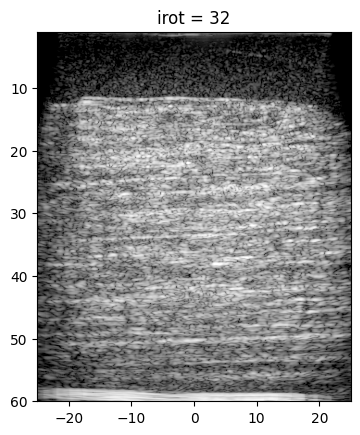

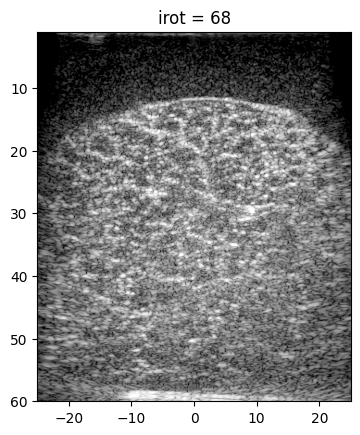

In [32]:
bmfrm = TabbedBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    interp={"kind":"korder_cubic", "k":16},
    sumtype='tx_and_rx'
)

irots = [32, 32+36]
ims = []
for irot in irots:
    subset = rf[:,irot,:,:].transpose(1, 0, 2)

    im = np.nan_to_num(bmfrm(subset).reshape(len(xout), len(zout)).T, copy=False)
    ims.append(im)

ims = np.array(ims)

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

for iirot, irot in enumerate(irots):
    env = np.abs(hilbert(ims[iirot], axis=0))
    logged = 20 * np.log10(env/np.percentile(env, 99))

    plt.figure()
    plt.imshow(logged, vmin=-45, vmax=5, extent=ex_axlat, cmap='gray')
    plt.title(f"irot = {irot}")
    plt.show()

In [33]:
dims_out = dict()
keys = ["rot_deg", "steer_deg", "xele_m", "t_sec"]
for key in keys:
    dims_out[key] = dims[key]

dims_out['rot_deg'] = dims['rot_deg'][np.array([32, 32+36])]
rf.shape

rf_out = np.ascontiguousarray(rf[:,np.array([32, 32+36]),:,:].transpose(1,2,0,3))
rf_out[:,:,np.array([9, 19, 39, 171]),:] = 0

dio.putdictasHDF5(
    "channel_data_exvivo_bovine.h5",
    dict(
        rf = rf_out,
        dims = dims_out,
        c0 = c,
        f0 = f,
        probe = 'GE9LD',
        notes = "Rx traces from elements 9, 19, 39, and 171 are zerod out bc they are dead"
    )
)